## Modelos Lineales - Parte 2. Sobreajuste y Validación Cruzada

## Sobreajuste

Discutimos la semana pasada el fenómeno del sobreajuste (*overfitting*), que ocurre cuando intentamos optimizar un modelo demasiado complejo para la cantidad de datos que tenemos.

Presentamos esto con el ejemplo de la regresión polinomial a datos sinusoidales. Vamos a ver esto más en detalle acá.

Primero, corremos la celda de preparación.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "06_Regularizacion"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

Generemos ahora un conjunto de datos sintéticos, similares a los del Bishop (ver Apéndice A del libro). Además, generemos un conjunto de testeo, que vamos a usar más tarde.

In [2]:
import numpy.random as rr

ndata = 10
ntest = 100
# 
x = rr.rand(ndata, 1)
xtest = rr.rand(ntest, 1)

# El modelo real (ground truth)
t = np.sin(2*np.pi * x)
ttest = np.sin(2*np.pi * xtest)

# Agregemos error normal a los datos, con desviación standard 0.3
t += rr.randn(ndata, 1) * 0.3
ttest += rr.randn(ntest, 1) * 0.3

# Arrays para representar el modelo verdadero
x_ = np.linspace(0, 1, 100)
t_  = np.sin(2*np.pi * x_)

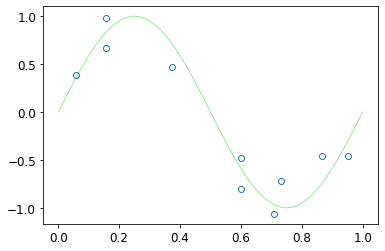

In [3]:
def plot_data_truth(ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    # Y veamos a qué se parece (hacemos una funcionn poruq esto lo vamos a usar mucho)
    ax.plot(x_, t_, '-', color='LightGreen', lw=1)
    ax.plot(x, t, 'o', mfc='None')
    return

plot_data_truth()

Vamos a intentar modelar estos datos con un modelo lineal, con funciones base polinomiales de orden $M$:

$$
y(x, \mathbf{w}) = \sum_{j=0}^M w_j \phi_j(x)\;\;,
$$

donde $\phi_j(x) = x^j$. Probemos grados diferentes, $M$. Para simplificar la cosa, escribimos una función que genere la matriz de diseño para el grado que querramos. 

**¿Se animan a codearla ustedes?** Recuerden que una función práctica de <tt>numpy</tt> es <tt>hstack</tt>.

In [4]:
def matrizdise(x, M=2):
    """
    Produce la matriz de diseño con features polinomiales de grado M
    
    :param x: vector columna con la variable input
    :type x: np.array of shape (n, 1)
    :param M: grado de las features polinomiales, defaults to 2.
    :type M: int, optional
    :return phi: matriz de diseño con features polinomiales
    :rtype: np.array of shape (n, M+1)
    """  
    phi = 0
    
    return phi

Por supuesto, existe algo en <tt>ScikitLearn</tt> que hace exactamente esto. Usemoslo y comparemos los resultados. Esto es una especie de prueba para el código que acaban de escribir.

In [5]:
import sklearn.preprocessing as pp

M = 9
polyfeat = pp.PolynomialFeatures(M)

# Como simpre, todas las clases tiene el método transform
phi = polyfeat.fit_transform(x)

In [6]:
# Verifiquemos si es lo mismo
#assert np.allclose(phi, matrizdise(x, polyfeat.degree)), "Algo está mal"

Para cada valor de M, vamos a querer calcular el RMSE en el conjuto de entrenamiento. Recuerden:

$$
\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(y(x_i, \mathbf{w_\mathrm{ML}}) - t_i\right)^2}\;\;.
$$
Vamos, entonces a escribir una función que implemente este error, dado el vector de predicciónes, $y(x_i, \mathbf{w}_\mathrm{ML})$ y los datos de entrenamiento $t_i$, con $i = {0, 1, ... , n}$.

Otra vez, les pido que lo hagan ustedes.

In [7]:
def rmse(t, y):
    """
    Produce la matriz de diseño con features polinomiales de grado M
    
    :param t: vector columna con los datos salida del conjunto de entrenamiento.
    :type t: np.array of shape (n, 1)
    :param y: vector columna con las predicciones del modelo.
    :type y: np.array of shape (n, 1)
    :return rmse: raíz del error medio cuadrático
    :rtype: float
    """  
    rmse = np.sqrt( np.sum((t - y)**2) / len(t) )
    
    return rmse

Y una vez más, parece que <tt>ScikitLearn</tt> se nos adelantó.

In [8]:
from sklearn.metrics import mean_squared_error

Por último, escribamos una claes (ojo ahí) que haga regresión de modelos lineales: que calcule los estimadores de máxima verosimilitud de los parámetros y que haga predicciones. Esto ya no es tan fácil, y nunca lo hicimos, pero es la puerta de ingreso a un mundo mejor: el mundo de la programación orientada a objetos. Acá va.

In [9]:
class RegresionLineal(object):
    
    def __init__(self):
        self.parametros = None
        self.prediccion = None
    
    def fit(self, Phi, t):
        """
        Ajusta el modelo lineal.

        :param Phi: matriz de diseño
        :type Phi: array-like de shape (n_muestras, n_features)
        :param t: valores verdaderos.
        :type t: array-like de shape (n_muestras, 1)

        :returns: self, una versión de sí mismo.
        """
        
        # Escribir la solución de las ecuaciones normales. De hecho, ya lo hicimos la semana pasada.
        # Acá está el código
        
        # Ahora calculemos el producto de phi por su transpuesta y verifiquemos que la forma es la correcta
        pp = np.dot(Phi.T, Phi)

        # y el producto entre phi y el vector t
        yy = np.dot(Phi.T, t)
        
        wml = np.linalg.solve(pp, yy)
        
        # Asegurarse de que el resultado queda guardado en la variable
        self.parametros = wml
        
        return
        
    def predict(self, Phi_pred):
        """
        Realiza predicciones para el arreglo de input x

        :param Phi_pred: Matriz de diseño calculada en los puntos en los que se quiere obtener una predicción.
        :type Phi_pred: array-like de shape (n_muestras, n_features)

        :returns t_pred: predicción para el arreglo de entrada (n_muestras, 1)
        """
        
        # En nuestro caso, n_variables = 1, pero está bueno escribir la función lo más general posible.
        # Esto también lo hicimos la semana pasada
        
        if self.parametros is None:
            raise AttributeError("Todavía no se ajustó ningún modelo")
        
        t_pred = Phi_pred @ self.parametros

        self.prediccion = t_pred
        
        return t_pred

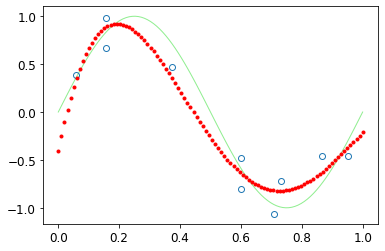

In [18]:
polyfeat = pp.PolynomialFeatures(4)
mirl = RegresionLineal()

phi = polyfeat.fit_transform(x)
mirl.fit(phi, t)
#print(mirl.parametros)
#print(mirl.predict(phi))

phi_ = polyfeat.fit_transform(x_[:, np.newaxis])
#print(phi_.shape)
ypred_ = mirl.predict(phi_)

plot_data_truth()
plt.plot(x_, ypred_, '.r')

A esta altura no sorprende que <tt>sklearn</tt> tenga algo muy similar. Veamos la documentación.

In [21]:
from sklearn.linear_model import LinearRegression

#LinearRegression?

Para hacer la regresión polinomial, vemos que entonces primero hay que calcular la matriz de diseño usando los features polinomiales y después resolver las ecuaciones normales. Por suerte, <tt>sklearn</tt> tiene una clase que permite hacer ambos pasos a la vez: se llama <tt>Pipeline</tt>

In [35]:
from sklearn.pipeline import Pipeline

polyregression = Pipeline([('features', pp.PolynomialFeatures(degree=5)),
                          ('regression', LinearRegression())
                          ])

Y ahora se puede hacer todo con un simple llamada a <tt>fit</tt>.

(-2.5, 2.5)

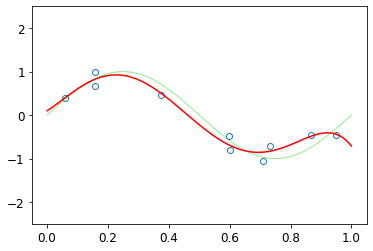

In [36]:
# Recordemos que x y t son los datos
plot_data_truth()

# Ajustemos el modelo a ellos
polyregression.fit(x, t)

# Y calculemos la predicción en un array bien muestreado y en los x de training
y = polyregression.predict(x)
y_ = polyregression.predict(x_[:, np.newaxis])

# ahora hagamos un plot
plt.plot(x_, y_, '-r')
plt.ylim(-2.5, 2.5)

Usemos la función que escribimos para calcular el RMSE, y veamos el valor de los coeficientes.

In [37]:

def print_results(polyreg, truth, prediction):
    rmse = mean_squared_error(prediction, truth)
    
    print('Error RMSE para un polinomio de grado {}'
          ': {:.3f}'.format(polyreg.named_steps['features'].degree, rmse))
    
    print('Los parámetros son {}'.format(polyreg.named_steps['regression'].coef_))
    
    return rmse, polyreg.named_steps['regression'].coef_

A = print_results(polyregression, y, t)

Error RMSE para un polinomio de grado 5: 0.016
Los parámetros son [[   0.            4.49142343   16.80431619 -130.95957887  198.41364721
   -89.5586847 ]]


Ahora sí, pongamos todo esto junto y armemos una función que ajuste los datos con polinomios de distintos órdenes, y devuelva el error y los parámetros.

Error RMSE para un polinomio de grado 0: 0.451
Los parámetros son [[0.]]
Error RMSE para un polinomio de grado 1: 0.145
Los parámetros son [[ 0.         -1.84643082]]
Error RMSE para un polinomio de grado 3: 0.031
Los parámetros son [[  0.           8.42895348 -26.89133486  18.58231352]]
Error RMSE para un polinomio de grado 4: 0.023
Los parámetros son [[  0.          15.99844373 -59.571269    68.76266946 -24.99595859]]
Error RMSE para un polinomio de grado 5: 0.016
Los parámetros son [[   0.            4.49142343   16.80431619 -130.95957887  198.41364721
   -89.5586847 ]]
Error RMSE para un polinomio de grado 6: 0.015
Los parámetros son [[   0.           17.75754544 -102.3462752   321.00042099 -622.34217105
   618.48206085 -233.28546038]]
Error RMSE para un polinomio de grado 7: 0.008
Los parámetros son [[      0.            1154.74654685  -11703.43075828   53833.90699279
  -128992.16591508  167190.26296311 -111218.49564226   29781.41390683]]


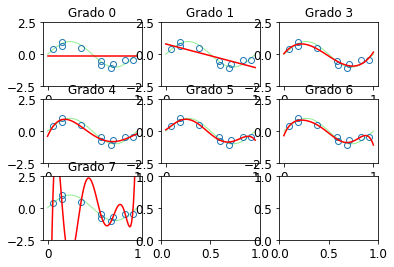

In [42]:
def fit_data(grados=[0, 1, 3, 5, 7], plot=True):
    
    if plot:
        fig, axs = plt.subplots(int(np.ceil(len(grados)/3)), 3)
    
    errors = np.zeros(len(grados))
    errorstest = np.zeros(len(grados))
    
    for i, grado in enumerate(grados):
        # Crea un pipeline de sklearn con features de grado "grado"
        modelo = Pipeline([('features', pp.PolynomialFeatures(degree=grado)),
                           ('regression', LinearRegression())
                          ])
        
        # Ajusta el modelo a los datos
        modelo = modelo.fit(x, t)
        
        # Calcula la predicción en el conjunto de entrenamiento
        y = modelo.predict(x)
        
        # Calcula la predicción en el conjunto de test
        ytest = modelo.predict(xtest)
        
        # Print y calcula errores
        errors[i] = print_results(modelo, t, y)[0]
        errorstest[i] = mean_squared_error(ytest, ttest)
        
        if plot:
            # Si vamos a hacer un plot, también para el array bien sampleado
            y_ = modelo.predict(x_[:, np.newaxis])
                                
            # Elige el eje adecuado            
            ax = axs[np.unravel_index(i, axs.shape)]
            
            # First plot data and truth
            plot_data_truth(ax)
            
            # Add prediction
            ax.plot(x_, y_, 'r-')
            ax.set_ylim(-2.5, 2.5)
            
            ax.set_title('Grado {}'.format(grado))
                
    return grados, errors, errorstest

grados, errors, errorstest = fit_data(grados=[0, 1, 3, 4, 5, 6, 7])

Hagamos ahora un gráfico parecido al de Bishop, que muestra el problema del overfitting.

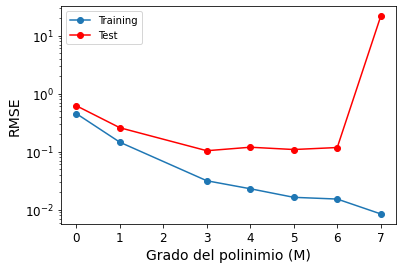

In [43]:
plt.plot(grados, errors, '-o', label='Training')
plt.semilogy(grados, errorstest, '-o', label='Test', color='r')

plt.xlabel('Grado del polinimio (M)')
plt.ylabel('RMSE')
plt.legend(loc=0)

***
Hasta acá revisitamos el concepto de sobreajuste y lo vimos en acción en un caso bien particular. Datos sinusoidales con una regresión polinomial. 

Vimos el uso de varias clases del paquete <tt>sklearn</tt>, en particular las que permiten hacer features polinomiales ([PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)), la que permite hacer regresión con modelos lineales, ([LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)), y la que permite automatizar varias acciones en un solo comando.
([Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)). Puse los links a la documentación de <tt>sklearn</tt>

En la guía de ejercicios se les pide que experimenten cambiando el número de puntos en el conjunto de entrenamiento, para que vean cómo cambia la severidad del sobreajuste con este parámetro.

Vemos que para detectar el sobreajuste, se necesita recurrir, en general, al conjunto de test. Esto es problemático, porque si se detecta *overfitting*, entonces ese conjunto ya no puede funcionar como conjunto de test, y necesitamos datos nuevos. Para resolver esto, se puede recurrir a la técnica de validación cruzada, que es lo que vamos a ver ahora.
***

## Validación cruzada

La semana pasada escribimos una función para separar aleatoriamente los datos en conjunto de test y de entrenamiento. El mismo procedimiento se podría emplear en el conjunto de entrenamiento para identificar conjuntos de validación. 

En realidad, existe un gran número de maneras para elegir el conjunto de validación y/o hacer validación cruzada. Una vez más, la [documentación de sklearn](https://scikit-learn.org/stable/modules/cross_validation.html) sobre este tema es un excelente punto de partida para enterarse de más.

La forma más sencilla para usar Cross Validation con sklearn es <tt>cross_val_score</tt>, que permite hacer K-folding fácilmente. Veamos un ejemplo:

In [44]:
from sklearn.model_selection import cross_val_score

modelo = Pipeline([('features', pp.PolynomialFeatures(degree=3)),
                    ('regression', LinearRegression())
                    ])

# Leave one out
scores = cross_val_score(modelo, x, t, cv=5, scoring='neg_mean_squared_error')
errores = -scores
print(errores, errores.mean(), errores.std())

[0.35316617 0.05568523 0.03855757 0.09549952 0.16531345] 0.14164438638090954 0.11440883186123359


Ahora puedo hacer una función parecida a la anterior, pero que calcule los scores con crossvalidation

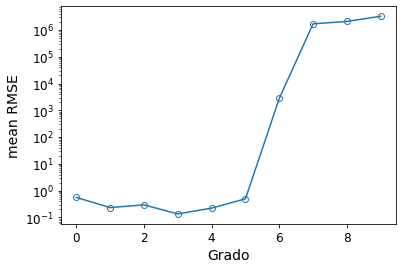

In [45]:
from sklearn.model_selection import cross_val_score, LeaveOneOut

def cv_multimodel(grados=range(10), cv=len(x), plot=True):
        
    rsmes = np.zeros(len(grados))
    std_rsmes = np.zeros(len(grados))
    
    for i, grado in enumerate(grados):
        # Crea un pipeline de sklearn con features de grado "grado"
        modelo = Pipeline([('features', pp.PolynomialFeatures(degree=grado)),
                           ('regression', LinearRegression())
                          ])
        
        # Hacer K-folding
        scores = cross_val_score(modelo, x, t, cv=cv, scoring='neg_mean_squared_error')
            
        # Como se usa un score, hay que pasarlo a Error cambiando de signo.
        rsmes[i] = (-scores).mean()
        std_rsmes[i] = (-scores).std()
        
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # Sin errores
        ax.semilogy(grados, rsmes, 'o-', mfc='None')
        
        # Con errores
#         ax.errorbar(grados, rsmes, std_rsmes, fmt='-o')
#         ax.set_yscale('log')
        
        ax.set_xlabel('Grado')
        ax.set_ylabel('mean RMSE')
                
    return grados, rsmes, std_rsmes

grados, errors, errorst = cv_multimodel()

# loo = LeaveOneOut()
# loo.get_n_splits(x)
# scores = []
# for train_index, test_index in loo.split(x):
#     modelo = modelo.fit(x[train_index], t[train_index])
#     y = modelo.predict(x[test_index])
#     scores.append(mean_squared_error(t[test_index], y, squared=True))
    
# scores = np.array(scores)

In [46]:
from sklearn.model_selection import cross_val_score

# Definir el mejor modelo, elegido a partir de CV
modelo = Pipeline([('features', pp.PolynomialFeatures(degree=3)),
                    ('regression', LinearRegression())
                    ])
# Ajustar con mi conjunto de training.
modelo.fit(x, t)

# Evaluar en el conjunto de test.
ytest = modelo.predict(xtest)
print('El error del mejor modelo en el conjunto de test es {:.2e}.'.format(mean_squared_error(ttest, ytest)))

# Leave one out
# scores = cross_val_score(modelo, x, t, cv=10, scoring='neg_root_mean_squared_error')
# errores = -scores
# print(errores, errores.mean(), errores.std())

El error del mejor modelo en el conjunto de test es 1.04e-01.


## Regularización

Veamos cómo funciona la regularización usando <tt>Ridge</tt> y <tt>Lasso</tt>. Ambas clases están definidas por con un hiperparámetro, $\alpha$, que equivale al coeficiente $\lambda$ que acabamos de ver.

In [49]:
from sklearn.linear_model import Ridge, Lasso

modelo = Pipeline([('features', pp.PolynomialFeatures(degree=5)),
                         ('regression', LinearRegression())
                          ])

modelo_ridge = Pipeline([('features', pp.PolynomialFeatures(degree=5)),
                         ('regression', Ridge(alpha=1e-4))
                          ])

modelo_lasso = Pipeline([('features', pp.PolynomialFeatures(degree=5)),
                         ('regression', Lasso(alpha=1e-4, tol=1e-3, max_iter=20000))
                          ])

No regularizado
[[   0.            4.49142343   16.80431619 -130.95957887  198.41364721
   -89.5586847 ]]
#######
Ridge
[[  0.           7.05890558 -21.66524181   7.07605537  14.12964036
   -6.73580415]]
#######
LASSO
[  0.           8.64987916 -27.05437386  12.48204295  14.78452034
  -8.95187909]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005802806363043422, tolerance: 0.00451287039048375
  positive)


(-1.5, 1.5)

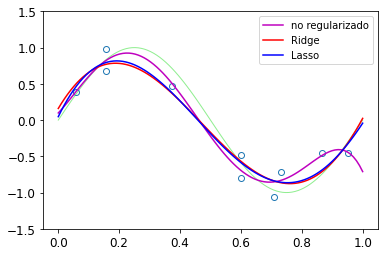

In [50]:
modelo = modelo.fit(x, t)
modelo_ridge = modelo_ridge.fit(x, t)
modelo_lasso = modelo_lasso.fit(x, t)

print('No regularizado')
print(modelo.named_steps['regression'].coef_)
print('#######')
print('Ridge')
print(modelo_ridge.named_steps['regression'].coef_)
print('#######')
print('LASSO')
print(modelo_lasso.named_steps['regression'].coef_)

y_ = modelo.predict(x_[:, np.newaxis])
yridge_ = modelo_ridge.predict(x_[:, np.newaxis])
ylasso_ = modelo_lasso.predict(x_[:, np.newaxis])

plot_data_truth()
plt.plot(x_, y_, '-m', label='no regularizado')
plt.plot(x_, yridge_, '-r', label='Ridge')
plt.plot(x_, ylasso_, '-b', label='Lasso')

plt.legend(loc=0)
plt.ylim(-1.5, 1.5)

Veamos cómo cambia el error en el conjuno de test con el parámetro alpha

El mejor valor de alpha es 8.48e-05


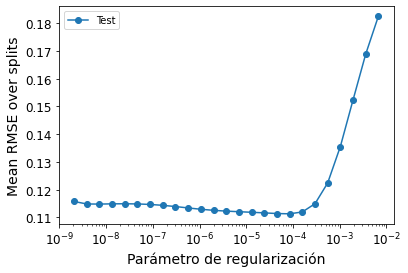

In [51]:
# Defino alphas
alphas = np.logspace(-20, -5, 25, base=np.e)

# Inicializo arreglo
#rmse_train = np.zeros_like(alphas) 
rmse_test = np.zeros_like(alphas)

for i, alpha in enumerate(alphas):
   
    modelo_ridge = Pipeline([('features', pp.PolynomialFeatures(degree=9)),
                             ('regression', Ridge(alpha=alpha))
                              ])
    # Ajusta el modelo
    modelo_ridge = modelo_ridge.fit(x, t)
    
    # Calcula la predicción en el conjunto de test y de train
    #ytrain = modelo_ridge.predict(x)
    ytest = modelo_ridge.predict(xtest)
    
    # Calcula el error
    #rmse_train[i] = mean_squared_error(t, ytrain, squared=False)
    rmse_test[i] = mean_squared_error(ttest, ytest)
    
# Ahora ploteo el resultado.
plt.semilogx(alphas, rmse_test, 'o-', label='Test')
#plt.loglog(alphas, rmse_train, 'o-', label='Train')
plt.xlabel('Parámetro de regularización')
plt.ylabel('Mean RMSE over splits')
plt.legend(loc=0)

print('El mejor valor de alpha es {:.2e}'.format(alphas[np.argmin(rmse_test)]))

Esto está muy bien, pero ahora el problema de la complejidad parece haberse trasladado a la elección del parámetro de regularización, $\alpha$. Acá de nuevo recurrimos a el conjunto de test para justar un (hiper)parámetro.

En lugar de eso, podemos usar de nuevo Cross-Validation. Existen algunas clases de <tt>sklearn</tt> muy poderosas que hacen todo eso junto.

El mejor valor para el coeficiente de regularización es 1.30e-05
Ridge
[[  0.           8.34633694 -19.30891791  -2.559876     6.93166391
    8.98060946   6.98157605   2.60162372  -3.22543148  -9.75327862]]
El error del mejor modelo en el conjunto de test es 1.12e-01.


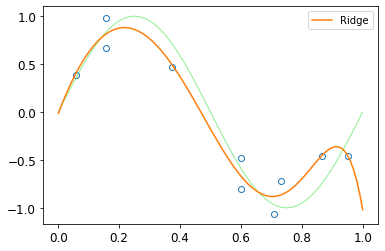

In [64]:
from sklearn.linear_model import RidgeCV, LassoCV

# Compute polinomial features
polyfeat = pp.PolynomialFeatures(degree=9)
phi = polyfeat.fit_transform(x)

# Regresión con Ridge haciendo CV en el hiperparámetro alpha
# Usamos cv=len(x) para hacer LOO-CV
ridgecv = RidgeCV(alphas=alphas, cv=len(x), scoring='neg_mean_squared_error')
ridgecv = ridgecv.fit(phi, t)

# Print
print('El mejor valor para el coeficiente de regularización es {:.2e}'.format(ridgecv.alpha_))

# Veamos el ajust
phi_ = polyfeat.fit_transform(x_[:, np.newaxis])
yridgecv_ = ridgecv.predict(phi_)

plot_data_truth()
plt.plot(x_, yridgecv_, label='Ridge')
plt.legend(loc=0)

print('Ridge')
print(ridgecv.coef_)

phitest = polyfeat.fit_transform(xtest)
ytest = ridgecv.predict(phitest)


print('El error del mejor modelo en el conjunto de test es {:.2e}.'.format(mean_squared_error(ttest, ytest)))